Mesh Parameterization
=====================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This tour explores 2-D parameterization of 3D surfaces using linear methods.


A  review paper for mesh parameterization can be found in:


M.S. Floater and K. Hormann,
_Surface Parameterization: a Tutorial and Survey_
in Advances in multiresolution for geometric modelling, p. 157-186, 2005.


See also:


K. Hormann,  K. Polthier and A. Sheffer
_Mesh parameterization: theory and practice,_
Siggraph Asia Course Notes

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
#from nt_solutions import meshdeform_1_parameterization as solutions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Conformal Laplacian
-------------------
The conformal Laplacian uses the cotan weights to obtain an accurate
discretization of the Laplace Beltrami Laplacian.


They where first introduces as a linear finite element approximation of the
Laplace-Beltrami operator in:


U. Pinkall and K. Polthier,
_Computing discrete minimal surfaces and their conjugates_
Experimental Mathematics, 2(1):15-36, 1993.


First load a mesh. The faces are stored in a matrix $F = (f_j)_{j=1}^m \in \RR^{3 \times m}$
of $m$ faces $f_j \in \{1,\ldots,n\}^3$. The position of the vertices are
stored in a matrix $X  = (x_i)_{i=1}^n \in \RR^{3 \times n}$ of $n$ triplets of points
$x_k \in \RR^3$

In [2]:
from nt_toolbox.read_mesh import * 

[X, F] = read_mesh("nt_toolbox/data/nefertiti.off")
n = np.shape(X)[1]

In order to perform mesh parameterization, it is important that this mesh
has the topology of a disk, i.e. it should have a single B.


First we compute the boundary $B = (i_1,\ldots,i_p)$ of the mesh.
By definition, for the edges $(i_k,i_{k+1})$, there is a single adjacent face $
(i_k,i_{k+1},\ell) $.

In [3]:
from nt_toolbox.compute_boundary import *
B = compute_boundary(F)

Length of the boundary.

In [4]:
p = len(B)

Display the boundary.

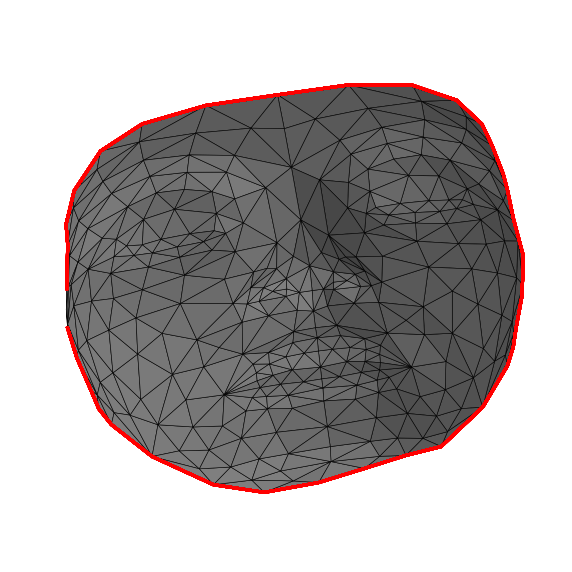

In [5]:
from nt_toolbox.plot_mesh import * 

plt.figure(figsize=(10,10))
#plot mesh
plot_mesh(X, F, el=80, az=-100, lwdt=.6, dist=6)

#plot boundary
for i in range(len(B)):
    plt.plot(X[0,B], X[1,B], X[2,B], color="red", lw=3)

The conformal Laplacian weight matrix $W \in \RR^{n \times n}$ is
defined as
$$ W_{i,j} =
      \choice{
          \text{cotan}(\al_{i,j}) + \text{cotan}(\be_{i,j})
          \qifq i \sim j \\
          \quad 0 \quad \text{otherwise}.
      }
$$
Here, $i \times j$ means that there exists two faces
$ (i,j,k) $ and $ (i,j,\ell) $ in the mesh (note that for B
faces, one has $k=\ell$).


The angles are the angles centered as $k$ and $\ell$, i.e.
$$ \al_{i,j} = \widehat{x_i x_k x_j }
  \qandq
  \be_{i,j} = \widehat{x_i x_\ell x_j }. $$


Compute the conformal 'cotan' weights.
Note that each angle $\alpha$ in the mesh contributes with
$1/\text{tan}(\alpha)$ to the weight of the opposite edge.
We compute $\alpha$ as
$$ \alpha = \text{acos}\pa{ \frac{\dotp{u}{v}}{\norm{u}\norm{v}} } $$
where $u \in \RR^3, v \in \RR^3$ are the edges of the adjacent vertices
that defines $\al$.

In [6]:
W = sparse.coo_matrix(np.zeros([n,n]))

for i in range(3):
    i2 = (i+1)%3
    i3 = (i+2)%3
    u = X[:,F[i2,:]] - X[:,F[i,:]]
    v = X[:,F[i3,:]] - X[:,F[i,:]]
    # normalize the vectors   
    u = u/np.tile(np.sqrt(np.sum(u**2,0)), (3,1))
    v = v/np.tile(np.sqrt(np.sum(v**2,0)), (3,1))
    # compute angles
    alpha = 1/np.tan(np.arccos(np.sum(u*v, 0)))
    alpha = np.maximum(alpha, 1e-2*np.ones(len(alpha))) #avoid degeneracy
    W = W + sparse.coo_matrix((alpha,(F[i2,:],F[i3,:])),(n,n))
    W = W + sparse.coo_matrix((alpha,(F[i3,:],F[i2,:])),(n,n))

Compute the symmetric Laplacian matrix
$L = D-W$ where $D = \mathrm{Diag}_i\pa{\sum_j W_{i,j}}$

In [7]:
d = W.sum(0)
D = sparse.diags(np.ravel(d),0)
L = D - W

Fixed Boundary Harmonic Parameterization
----------------------------------------
The problem of mesh parameterization corresponds to finding
2-D locations $(y_i = (y_i^1,y_i^2) \in \RR^2$
for each original vertex, where $ Y = (y_i)_{i=1}^n \in \RR^{2 \times n} $
denotes the flattened positions.


The goal is for this parameterization to be valid, i.e. the 2-D
mesh obtained by replacing $X$ by $Y$ but keeping the same face connectivity $F$
should not contained flipped faces (all face should have the same orientation in the plane).



We consider here a linear methods, that finds the parameterization, that
impose that the coordinates are harmonic inside the domain, and have
fixed position on the boundary (Dirichlet conditions)
$$ \forall s=1,2, \quad \forall i \notin B, \quad (L y^s)_i = 0,
\qandq \forall j \in B, \quad y^s_j = z_j^s. $$


In order for this method to define a valid parameterization, it is
necessary that the fixed position $ z_j = (z^1_j,z^2_j) \in \RR^2 $
are consecutive points along a convex polygon.


Compute the fixed positions $Z=(z_j)_j$ for the vertices on $B$.
Here we use a circle.

In [8]:
p = len(B)
t = np.linspace(0,2*np.pi,p+1)
t = np.delete(t,p)
Z = np.vstack((np.cos(t),np.sin(t)))

Computing the parameterization requires to solve two independent linear
system
$$ \forall s=1,2, \quad  L_1 y^s = r^s $$
where $L_1$ is a modified Laplacian, the is obtained from $L$ by
$$ \choice{
      \forall i \notin B, \quad (L_0)_{i,j} = L_{i,j} \\
      \forall i \in B, \quad (L_0)_{i,i}=1, \\
      \forall i \in B, \forall j \neq i, \quad (L_0)_{i,i}=0,
  } $$
i.e. replacing each row indexed by $B$ by a 1 on the diagonal.

In [9]:
L1 = np.copy(L.toarray())
L1[B,:] = 0
for i in range(len(B)):
    L1[B[i], B[i]] = 1
L1 = sparse.coo_matrix(L1)

Set up the right hand size $R$ with the fixed position.

In [10]:
R = np.zeros([2,n])
R[:,B] = Z

Solve the two linear systems.

In [11]:
from scipy.sparse import linalg

Y = np.zeros([2,n])
Y[0,:] = linalg.spsolve(L1, R[0,:])
Y[1,:] = linalg.spsolve(L1, R[1,:])

Display the parameterization.

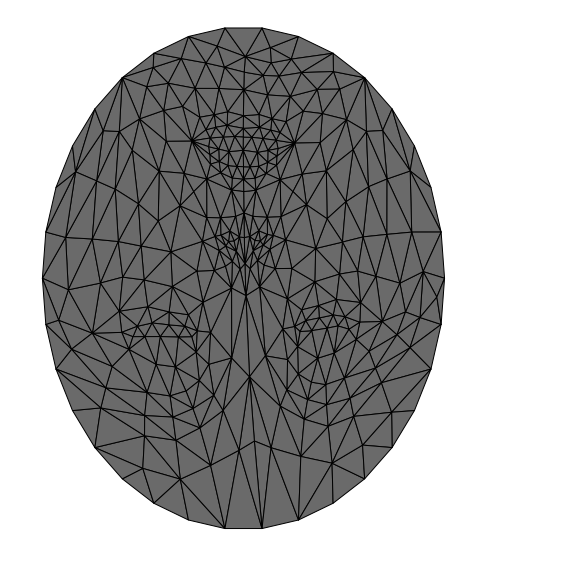

In [12]:
plt.figure(figsize=(10,10))
plot_mesh(np.vstack((Y,np.zeros(n))),F, lwdt=1, c="lightgrey")

Mesh Parameterization on a Square
---------------------------------
One can perform a fixed B parameterization on a square.
This is useful to compute a geometry image (a color image storring the
position of the vertices).

__Exercise 1__

Compute the fixed positions $Z$ of the points indexed by $B$ that are along a
square. Warning: $p$ is not divisible by 4.

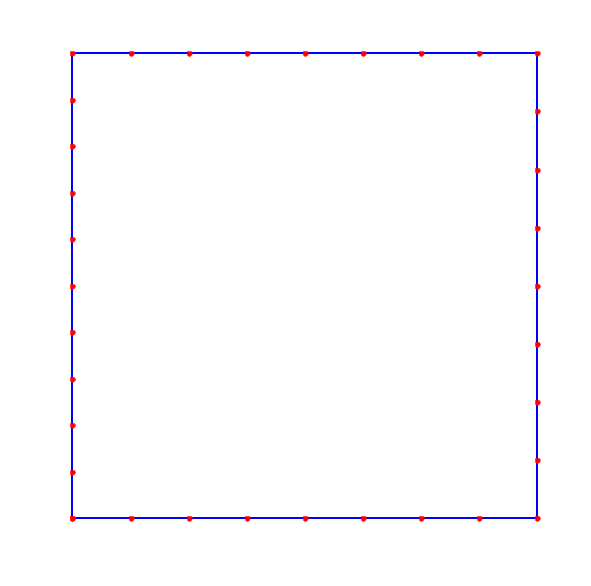

In [13]:
run -i nt_solutions/meshdeform_1_parameterization/exo1

In [14]:
## Insert your code here.

__Exercise 2__

Compute the parameterization $Y$ on a square.

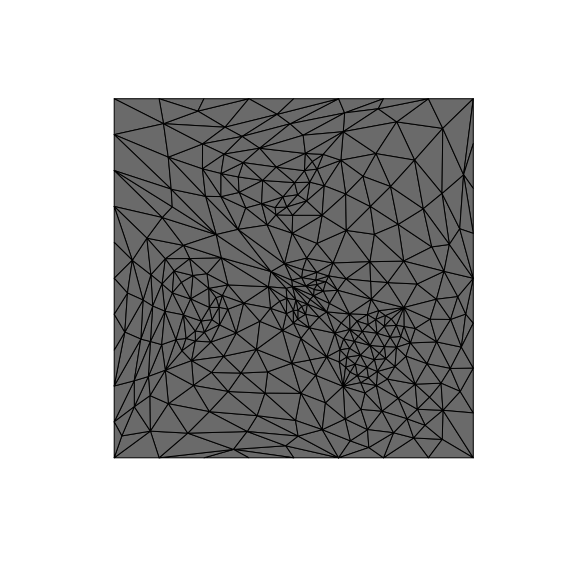

In [15]:
run -i nt_solutions/meshdeform_1_parameterization/exo2

In [16]:
## Insert your code here.

__Exercise 3__

Shift the $B$ positions so that the eyes of the model are approximately
horizontal.

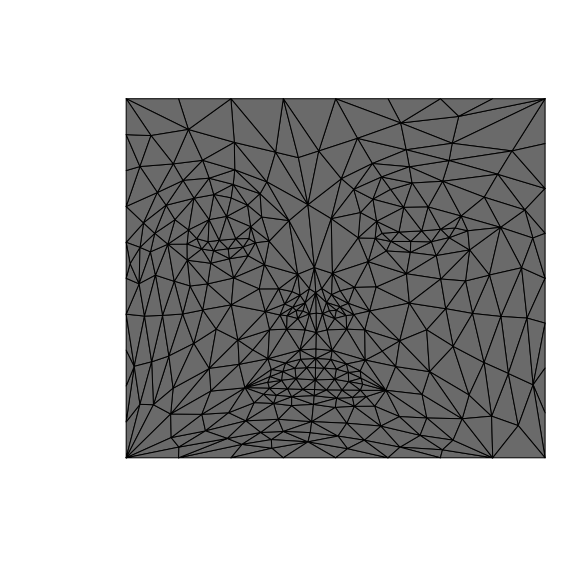

In [17]:
run -i nt_solutions/meshdeform_1_parameterization/exo3

In [18]:
## Insert your code here.

Re-align the Texture
--------------------
To map correctly a real image on the surface, the texture needs to be aligned.
We use here a simple affine mapping to map the eye and mouth of the image
on the corresponding location on the surface.


Load a texture image $T$.

In [19]:
from numpy import random

C = random.rand(1000,3)
C = C/np.repeat(np.sum(C,1)[:,np.newaxis],3,1)
C[np.lexsort((C[:,2],C[:,1],C[:,0]))]

lambd=np.transpose(C)

In [20]:
n1 = 256
T = load_image("nt_toolbox/data/lena.bmp", n1)
T = T[::-1,:]

Display the texture on the mesh, using the parametrization of the mesh as
texture coordinates.

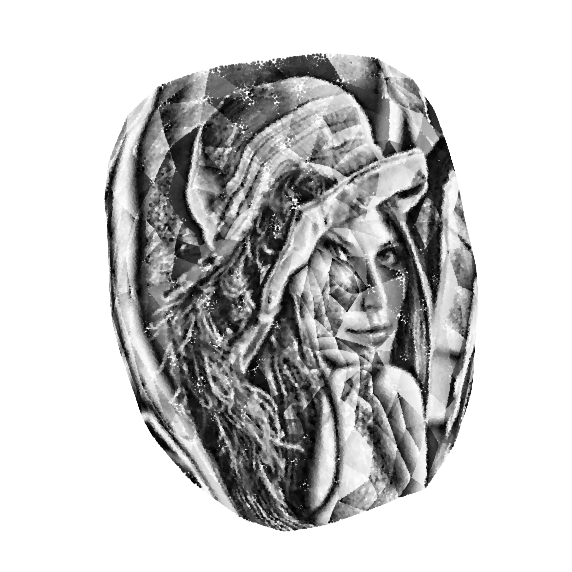

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from scipy import interpolate

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 1, np.shape(T)[0])
f = interpolate.RectBivariateSpline(x, x, np.transpose(T))

for i in range(np.shape(F)[1]):
    
    px = Y[0,F[:,i]]
    py = Y[1,F[:,i]]
    
    points_x = np.dot(np.transpose(lambd),px[:,np.newaxis])
    points_y = np.dot(np.transpose(lambd),py[:,np.newaxis])
    points = np.hstack((points_x,points_y))
    
    col = rescale(f.ev(points_x, points_y))
    col = np.repeat(col,3,1)
    
    Px = X[0,F[:,i]]
    Py = X[1,F[:,i]]
    Pz = X[2,F[:,i]]
    
    Points_x = np.dot(np.transpose(lambd),Px[:,np.newaxis])
    Points_y = np.dot(np.transpose(lambd),Py[:,np.newaxis])
    Points_z = np.dot(np.transpose(lambd),Pz[:,np.newaxis])

    ax.scatter(Points_x,Points_y,Points_z,c=col,s=5,lw=0,alpha=1)
    ax.view_init(elev=80, azim=-100)
    ax.axis("off")
    ax.dist=5

Position $(u_1,u_2,u_3)$ of the eyes and the mouth in the texture.

In [22]:
u1 = np.array([247,266])*n1/512.
u2 = np.array([247,328])*n1/512.
u3 = np.array([161,301])*n1/512.

Display.

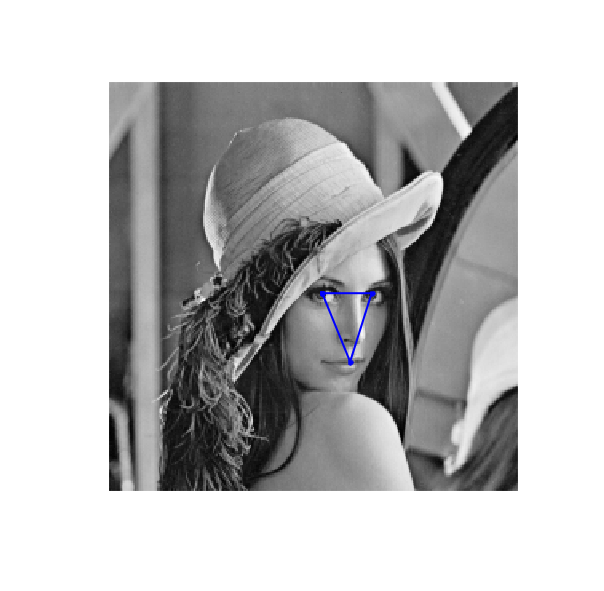

In [23]:
plt.figure(figsize=(10,10))
imageplot(T)
plt.plot([u1[1],u2[1],u3[1],u1[1]], [u1[0],u2[0],u3[0],u1[0]], '.-b', ms=10, linewidth=2)
plt.gca().invert_yaxis()
plt.show()

Positions $(v_1,v_2,v_3)$ of the eyes and the mouth on the parameteric domain

In [24]:
v1 = np.array([310,125])*n1/512.
v2 = np.array([315,350])*n1/512.
v3 = np.array([105,232])*n1/512.

Display.

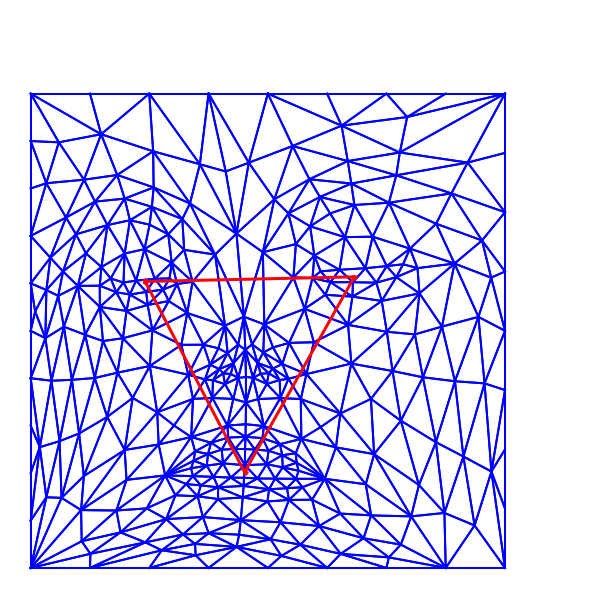

In [25]:
plt.figure(figsize=(10,10))
plt.axis("off")

Y_big = Y*(n1-1) + 1
beg = sparse.find(W)[0]
end = sparse.find(W)[1]

for i in range(len(beg)):
    plt.plot([Y_big[0, beg[i]], Y_big[0,end[i]]],[Y_big[1,beg[i]], Y_big[1,end[i]]],c="blue",lw=2)

plt.plot([v1[1],v2[1],v3[1],v1[1]], [v1[0],v2[0],v3[0],v1[0]], '.-r', ms=10, linewidth=3)
plt.show()

Apply a similitude to the image so that the mouth and the eye have the correct position in parametric domain.

In [26]:
from nt_toolbox.perform_image_similitude import *
T1 = np.transpose(perform_image_similitude(T,'affine',(u1-1)/n1,(v1-1)/n1,(u2-1)/n1,(v2-1)/n1,(u3-1)/n1,(v3-1)/n1))

Display the mesh with the image overlaid.

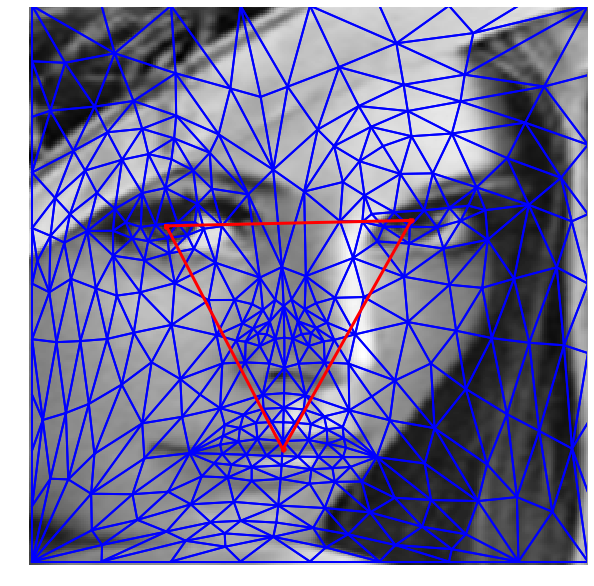

In [27]:
plt.figure(figsize=(10,10))
plt.axis("off")

Y_big = Y*(n1-1) + 1
beg = sparse.find(W)[0]
end = sparse.find(W)[1]

for i in range(len(beg)):
    plt.plot([Y_big[0, beg[i]], Y_big[0,end[i]]],[Y_big[1,beg[i]], Y_big[1,end[i]]],c="blue",lw=2)

plt.plot([v1[1],v2[1],v3[1],v1[1]], [v1[0],v2[0],v3[0],v1[0]], '.-r', ms=10, linewidth=3)
imageplot(T1)
plt.gca().invert_yaxis()
plt.show()

Display the texture mapped mesh.

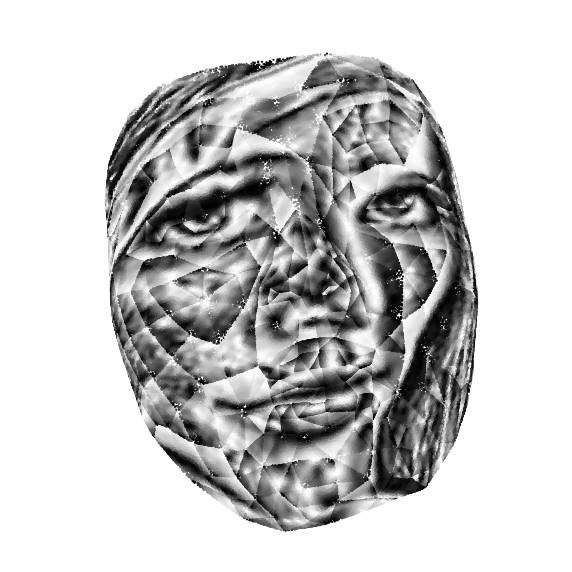

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from scipy import interpolate

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 1, np.shape(T)[0])
f = interpolate.RectBivariateSpline(x, x, np.transpose(T1))

for i in range(np.shape(F)[1]):
    
    px = Y[0,F[:,i]]
    py = Y[1,F[:,i]]
    
    points_x = np.dot(np.transpose(lambd),px[:,np.newaxis])
    points_y = np.dot(np.transpose(lambd),py[:,np.newaxis])
    points = np.hstack((points_x,points_y))
    
    col = rescale(f.ev(points_x, points_y))
    col = np.repeat(col,3,1)
    
    Px = X[0,F[:,i]]
    Py = X[1,F[:,i]]
    Pz = X[2,F[:,i]]
    
    Points_x = np.dot(np.transpose(lambd),Px[:,np.newaxis])
    Points_y = np.dot(np.transpose(lambd),Py[:,np.newaxis])
    Points_z = np.dot(np.transpose(lambd),Pz[:,np.newaxis])

    ax.scatter(Points_x,Points_y,Points_z,c=col,s=5,lw=0,alpha=1)
    ax.view_init(elev=80, azim=-100)
    ax.axis("off")
    ax.dist=5